In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw




Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw




Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw




Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [8]:
28*28

784

### Create generator and discriminator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [10]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

### Create necessary variables

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [11]:
from IPython.display import clear_output
import sys

In [12]:
def train(discriminator, generator, criterion, config, dataloader, device='cuda'):
  input = Variable(torch.FloatTensor(config.batch_size, 28*28)).to(device)
  noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).to(device)
  fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
  label = Variable(torch.FloatTensor(config.batch_size)).to(device)
  discriminator.to(device)
  generator.to(device)
  real_label = 1
  fake_label = 0
  ERRD_x = np.zeros(config.num_epochs)
  ERRD_z = np.zeros(config.num_epochs)
  ERRG = np.zeros(config.num_epochs)
  optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
  optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
  N = len(dataloader)
  errorsD_x = []
  errorsD_z = []
  errorsG = []

  for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(config.batch_size, -1).to(device)
        output = discriminator(input_data)
        #label.view(config.batch_size, 1
        errD_x = criterion(output.to(device), label.view(config.batch_size,1).to(device))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output.to(device), label.view(config.batch_size,1).to(device))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output.to(device), label.view(config.batch_size,1).to(device))
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            clear_output(True)
            errorsD_x.append(errD_x.item())
            errorsD_z.append(errD_z.item())
            errorsG.append(errG.item())
            sys.stdout.write('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
            plot = True
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(2, 2, 1)
                plt.plot(errorsD_x, label='discriminator errors on true images')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)

                plt.subplot(2, 2, 2)
                plt.plot(errorsD_z, label='discriminator errors on fake images')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)

                plt.subplot(2, 1, 2)
                plt.plot(errorsG, label='generator error')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()

Epoch:10 Iter: 3700 errD_x: 0.51 errD_z: 0.27 errG: 2.11

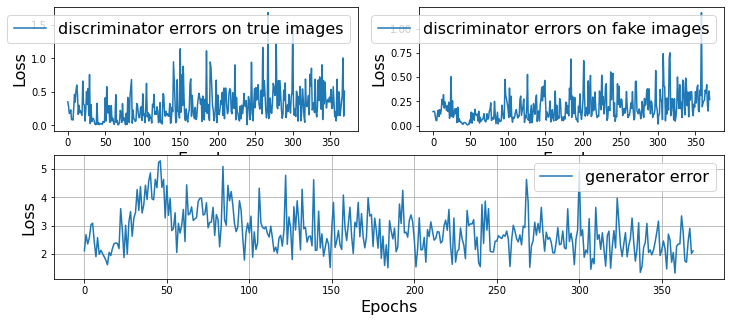

In [ ]:
train(discriminator, generator, nn.BCELoss(), config, dataloader, 'cuda')

In [13]:
def print_samples(generator, device='cuda'):
  generator.to(device)
  noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
  noise.data.normal_(0, 1)
  fake = generator(noise)

  plt.figure(figsize=(6, 7))
  for i in range(16):
      plt.subplot(4, 4, i + 1)
      plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
      plt.axis('off')

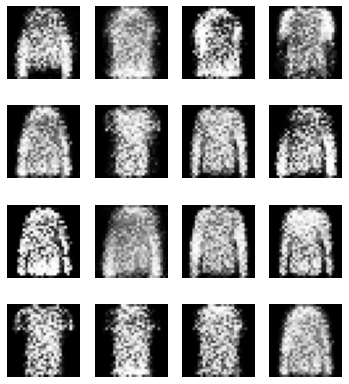

In [ ]:
print_samples(generator)

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

def interpolate_points(p1, p2, n_steps=10):
	ratios = np.linspace(0, 1, num=n_steps)
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)

def print_interpolation(generator):
  generator.to('cpu')
  pts = generate_latent_points(config.noise_size, 2)
  interpolated = interpolate_points(pts[0], pts[1])
  X = (generator(torch.FloatTensor(interpolated)) + 1) / 2.0
  plt.figure(figsize=(14, 7))
  for i, sample in enumerate(X):
    plt.subplot(1, len(interpolated), 1 + i)
    plt.axis('off')
    plt.imshow(sample.detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
  plt.show()

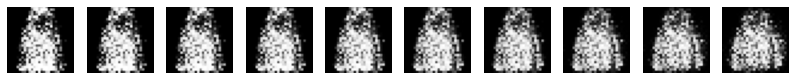

In [ ]:
print_interpolation(generator)

In [ ]:
class LSGenerator(nn.Module):
    def __init__(self):
        super(LSGenerator, self).__init__()
        self.model = nn.Sequential( 
            nn.ConvTranspose2d(50, 256, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(-1, 50, 1, 1)
        x = self.model(x)
        return x

class LSDiscriminator(nn.Module):
    def __init__(self):
        super(LSDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.last_linear = nn.Sequential(nn.Linear(2*2*512, 1), nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.model(x)
        x = x.view(-1, 2*2*512)
        return self.last_linear(x)

Epoch:10 Iter: 3700 errD_x: 0.00 errD_z: 0.00 errG: 1.00

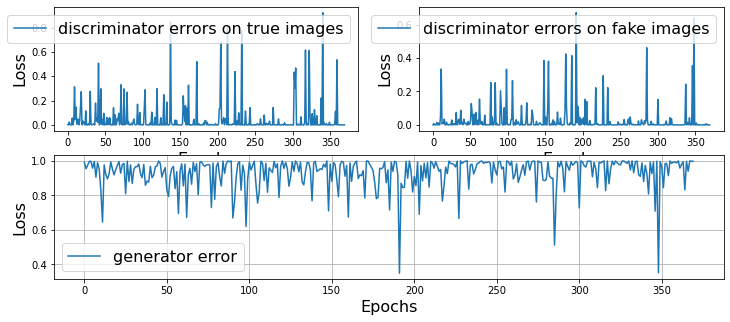

In [ ]:
discriminatorLS =  LSDiscriminator()
generatorLS = LSGenerator()
train(discriminatorLS, generatorLS, nn.MSELoss(), config, dataloader, 'cuda')

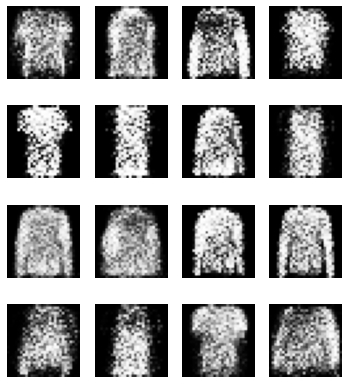

In [ ]:
print_samples(generator)

In [14]:
class ConditionalGenerator(nn.Module):
    def __init__(self):
      super(ConditionalGenerator, self).__init__()
      self.model = nn.Sequential(
          nn.Linear(50 + 10, 200),
          nn.ReLU(inplace=True),
          nn.Linear(200, 28*28),
          nn.Sigmoid())
      self.emb = nn.Embedding(10, 10)
        
    def forward(self, x, labels):
      c = self.emb(labels)
      x = torch.cat([x,c], 1)
      return self.model(x).squeeze()
    
class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
        self.emb = nn.Embedding(10, 10)
        
    def forward(self, x, labels):
      c = self.emb(labels)
      x = torch.cat([x,c], 1)
      return self.model(x)

In [23]:
def train_conditional_GAN(discriminator, generator, criterion, config, dataloader, device='cuda'):
  input = Variable(torch.FloatTensor(config.batch_size, 28*28)).to(device)
  noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).to(device)
  fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
  label = Variable(torch.FloatTensor(config.batch_size)).to(device)
  discriminator.to(device)
  generator.to(device)
  real_label = 1
  fake_label = 0
  ERRD_x = np.zeros(config.num_epochs)
  ERRD_z = np.zeros(config.num_epochs)
  ERRG = np.zeros(config.num_epochs)
  optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
  optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
  N = len(dataloader)
  errorsD_x = []
  errorsD_z = []
  errorsG = []

  for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(config.batch_size, -1).to(device)
        output = discriminator(input_data, cat.to(device))
        #label.view(config.batch_size, 1
        errD_x = criterion(output.to(device), label.view(config.batch_size,1).to(device))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        # fake
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, config.batch_size))).to(device)
        noise.data.normal_(0, 1)
        fake = generator(noise, fake_labels)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach(), fake_labels)
        errD_z = criterion(output.to(device), label.view(config.batch_size,1).to(device))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake, fake_labels)
        errG = criterion(output.to(device), label.view(config.batch_size,1).to(device))
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            clear_output(True)
            errorsD_x.append(errD_x.item())
            errorsD_z.append(errD_z.item())
            errorsG.append(errG.item())
            sys.stdout.write('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
            plot = True
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(2, 2, 1)
                plt.plot(errorsD_x, label='discriminator errors on true images')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)

                plt.subplot(2, 2, 2)
                plt.plot(errorsD_z, label='discriminator errors on fake images')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)

                plt.subplot(2, 1, 2)
                plt.plot(errorsG, label='generator error')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()

In [21]:
generatorC = ConditionalGenerator()
discriminatorC = ConditionalDiscriminator()

Epoch:10 Iter: 3700 errD_x: 0.21 errD_z: 0.25 errG: 2.10

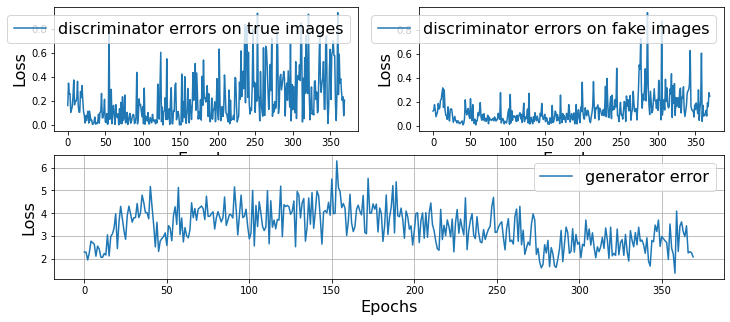

In [24]:
loss = nn.BCELoss()
train_conditional_GAN(discriminatorC, generatorC, loss, config, dataloader, 'cuda')

In [25]:
def print_samples(generator, config, device='cuda'):
  generator.to(device)
  noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()

  noise.data.normal_(0, 1)
  fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, config.batch_size))).to(device)
  fake = generator(noise, fake_labels)
  plt.figure(figsize=(6, 7))
  for i in range(16):
      plt.subplot(4, 4, i + 1)
      plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
      plt.axis('off')

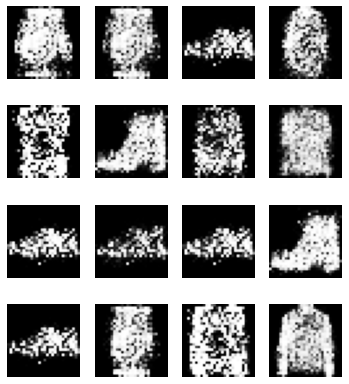

In [28]:
print_samples(generatorC, config)

Наиболее хорошие изображения а также лучший результат по схоимости (минимальный лосс) показал, кажется, LSGan. В то же время LSGan очень долго обучался. С другой стороны первый вариант и условный генератор дали более графики падения loss, также, они быстрее обучились.